In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,LSTM,Dense
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [3]:
df = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_train.xlsx")

In [4]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


In [5]:
df_truth = pd.read_excel("D:\\Projects\\BDA\\aircraft_reliability\\data\\PM_truth.xlsx")

In [6]:
df_merged = pd.merge(df, df_truth, on='id')
df_merged

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,more
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,98
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,98
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,98
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,98
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20426,99,181,-0.0015,-0.0001,100,518.67,643.72,1600.39,1428.03,14.62,...,2388.29,8123.55,8.4885,0.03,396,2388,100,38.50,23.0425,20
20427,99,182,-0.0027,-0.0003,100,518.67,643.52,1605.33,1430.32,14.62,...,2388.27,8130.99,8.5124,0.03,393,2388,100,38.39,22.9674,20
20428,99,183,-0.0031,-0.0003,100,518.67,643.96,1606.95,1427.90,14.62,...,2388.31,8126.90,8.5374,0.03,395,2388,100,38.57,23.1440,20
20429,99,184,-0.0010,-0.0001,100,518.67,644.10,1600.20,1436.54,14.62,...,2388.33,8125.66,8.5592,0.03,395,2388,100,38.45,23.0478,20


In [7]:
# Step 1: Get the maximum cycle for each engine
max_cycle_per_engine = df.groupby('id')['cycle'].max().reset_index()
max_cycle_per_engine.columns = ['id', 'max_cycle']

# Step 2: Merge the maximum cycle with the df_truth to get the actual failure cycle
df_merged = pd.merge(max_cycle_per_engine, df_truth, on='id')

# Step 3: Calculate the actual failure cycle (when engine will fail)
df_merged['failure_cycle'] = df_merged['max_cycle'] + df_merged['more']

# Step 4: Merge this back with the main DataFrame to compute remaining cycles
df = pd.merge(df, df_merged[['id', 'failure_cycle']], on='id')

# Step 5: Calculate remaining cycles for each row by subtracting the current cycle from the failure cycle
df['remaining_cycles'] = df['failure_cycle'] - df['cycle']
df = df.drop('failure_cycle',axis=1)

In [8]:
df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,remaining_cycles
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,289
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,288
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,287
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,286
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,285


In [ ]:
data = df.copy()

In [ ]:
import pandas as pd
import numpy as np

# Define function to create sequences for different scales
def create_aligned_sequences(data, short_term_len, medium_term_len, downsample=1):
    short_term_sequences = []
    medium_term_sequences = []
    targets = []

    for engine_id in data['id'].unique():
        engine_data = data[data['id'] == engine_id]

        # Minimum range to allow both short- and medium-term sequences to fit
        max_start = len(engine_data) - max(short_term_len, medium_term_len) + 1

        for i in range(max_start):
            # Short-term sequence (no downsampling)
            short_sequence = engine_data.iloc[i:i + short_term_len]
            # Medium-term sequence with downsampling
            medium_sequence = engine_data.iloc[i:i + medium_term_len].iloc[::downsample]

            # Ensure the lengths are as expected
            if len(short_sequence) == short_term_len and len(medium_sequence) == (medium_term_len // downsample):
                short_term_sequences.append(short_sequence.drop(columns=['id', 'cycle', 'remaining_cycles']).values)
                medium_term_sequences.append(medium_sequence.drop(columns=['id', 'cycle', 'remaining_cycles']).values)
                # Target at the end of the sequence
                targets.append(engine_data['remaining_cycles'].iloc[i + short_term_len - 1])

    return np.array(short_term_sequences), np.array(medium_term_sequences), np.array(targets)

# Generate aligned sequences
short_term_sequences, medium_term_sequences, targets = create_aligned_sequences(
    data, short_term_len=10, medium_term_len=50, downsample=5
)


# Check shapes
print("Short-term sequences shape:", short_term_sequences.shape)
print("Short-term targets shape:", short_term_targets.shape)
print("Medium-term sequences shape:", medium_term_sequences.shape)
print("Medium-term targets shape:", medium_term_targets.shape)


Short-term sequences shape: (15580, 10, 24)
Short-term targets shape: (19540,)
Medium-term sequences shape: (15580, 10, 24)
Medium-term targets shape: (15580,)


In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the model
def create_rnn_model(input_shape_short, input_shape_medium):
    short_input = Input(shape=input_shape_short)
    medium_input = Input(shape=input_shape_medium)

    # Short-term branch
    short_lstm = LSTM(64, return_sequences=True)(short_input)
    short_lstm = Dropout(0.2)(short_lstm)
    short_lstm = LSTM(32)(short_lstm)

    # Medium-term branch
    medium_lstm = LSTM(64, return_sequences=True)(medium_input)
    medium_lstm = Dropout(0.2)(medium_lstm)
    medium_lstm = LSTM(32)(medium_lstm)

    # Concatenate branches
    merged = Concatenate()([short_lstm, medium_lstm])
    dense = Dense(32, activation='relu')(merged)
    output = Dense(1)(dense)  # Output layer for RUL prediction

    model = tf.keras.Model(inputs=[short_input, medium_input], outputs=output)
    return model

# Create the model
input_shape_short = (10, 24)  # Example shape for short-term sequences
input_shape_medium = (10, 24)  # Example shape for medium-term sequences
model = create_rnn_model(input_shape_short, input_shape_medium)

In [ ]:
def create_sequences(df, sequence_length=50):
    X_seq, y_seq = [], []
    for engine_id, group in df.groupby('id'):
        # Ensure the group is sorted by cycle
        group = group.sort_values('cycle')
        # Create sequences
        for start in range(len(group) - sequence_length):
            end = start + sequence_length
            sequence = group.iloc[start:end]
            X_seq.append(sequence[['setting1', 'setting2', 'setting3'] + [f's{i}' for i in range(1, 22)]].values)
            y_seq.append(sequence['remaining_cycles'].values[-1])
    return np.array(X_seq), np.array(y_seq)

In [ ]:

# Set sequence length
sequence_length = 50
X_seq, y_seq = create_sequences(df, sequence_length)

# Normalize the feature data
scaler = StandardScaler()
num_features = X_seq.shape[2]
X_seq_reshaped = X_seq.reshape(-1, num_features)  # Flatten for scaling
X_seq_scaled = scaler.fit_transform(X_seq_reshaped)
X_seq_scaled = X_seq_scaled.reshape(X_seq.shape)  # Reshape back to sequence shape

X_train, X_test, y_train, y_test = train_test_split(X_seq_scaled, y_seq, test_size=0.2, random_state=42)

In [ ]:
X_seq.shape

(15481, 50, 24)

In [ ]:
def create_custom_cnn(input_shape):
    model = Sequential()
    
    # First convolutional block
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    
    # Second convolutional block
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    
    # Flatten and dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(50, activation='relu'))  # 50-dimensional embedding output
    
    return model

In [ ]:
# Compile and train the CNN on the training set
cnn_input_shape = (sequence_length, num_features)  # Adjust this according to your data
cnn_model = create_custom_cnn(cnn_input_shape)

cnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
cnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/50
194/194 [==============================] - 3s 10ms/step - loss: 7416.2207 - val_loss: 3281.1199
Epoch 2/50
194/194 [==============================] - 2s 8ms/step - loss: 3667.2097 - val_loss: 3047.2839
Epoch 3/50
194/194 [==============================] - 2s 9ms/step - loss: 2953.4014 - val_loss: 2185.4011
Epoch 4/50
194/194 [==============================] - 2s 8ms/step - loss: 2353.8044 - val_loss: 1845.1661
Epoch 5/50
194/194 [==============================] - 2s 8ms/step - loss: 1931.5361 - val_loss: 1609.1470
Epoch 6/50
194/194 [==============================] - 2s 10ms/step - loss: 1544.5271 - val_loss: 1125.3634
Epoch 7/50
194/194 [==============================] - 2s 10ms/step - loss: 1256.2251 - val_loss: 901.7744
Epoch 8/50
194/194 [==============================] - 2s 11ms/step - loss: 991.3305 - val_loss: 706.1138
Epoch 9/50
194/194 [==============================] - 2s 10ms/step - loss: 830.1860 - val_loss: 1712.6884
Epoch 10/50
194/194 [========================

In [ ]:
# Extract embeddings using the trained CNN
embedding_model = Sequential(cnn_model.layers[:-1])  # Use all layers except the final Dense layer
train_embeddings = embedding_model.predict(X_train)  # Generate embeddings for training data
test_embeddings = embedding_model.predict(X_test)    # Generate embeddings for test data


97/97 [==============================] - 0s 3ms/step


In [ ]:
train_embeddings.shape

(12384, 128)

In [ ]:
timesteps = 64
n_sequences = train_embeddings.shape[0] // timesteps

# Reshape the embeddings for the RNN input
rnn_input = train_embeddings[:n_sequences * timesteps].reshape((n_sequences, timesteps, 128))

print(rnn_input.shape)  # Should be (193, 64, 128)

(193, 64, 128)


In [ ]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(timesteps, 128)))  # Adjust the number of LSTM units as needed
model.add(Dense(1, activation='sigmoid'))  # Example for binary classification

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Reshape y_train as well to match the new sequence count
y_train_reshaped = y_train[:n_sequences * timesteps].reshape((n_sequences, timesteps))
y_train_seq_labels = y_train_reshaped[:, -1]  # Take the last label from each sequence

y_train_reshaped.shape

(193, 64)

In [ ]:
history = model.fit(rnn_input, y_train_seq_labels, 
                    epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
5/5 [==============================] - 2s 156ms/step - loss: -63.0424 - accuracy: 0.0000e+00 - val_loss: -304.4431 - val_accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 24ms/step - loss: -439.4401 - accuracy: 0.0000e+00 - val_loss: -806.9393 - val_accuracy: 0.0000e+00
Epoch 3/100
5/5 [==============================] - 0s 27ms/step - loss: -887.2967 - accuracy: 0.0000e+00 - val_loss: -1191.0934 - val_accuracy: 0.0000e+00
Epoch 4/100
5/5 [==============================] - 0s 26ms/step - loss: -1119.8195 - accuracy: 0.0000e+00 - val_loss: -1371.7723 - val_accuracy: 0.0000e+00
Epoch 5/100
5/5 [==============================] - 0s 27ms/step - loss: -1307.9003 - accuracy: 0.0000e+00 - val_loss: -1505.7273 - val_accuracy: 0.0000e+00
Epoch 6/100
5/5 [==============================] - 0s 26ms/step - loss: -1403.5225 - accuracy: 0.0000e+00 - val_loss: -1614.6736 - val_accuracy: 0.0000e+00
Epoch 7/100
5/5 [==============================] - 0s 26ms/step - los

In [ ]:
h = history.history

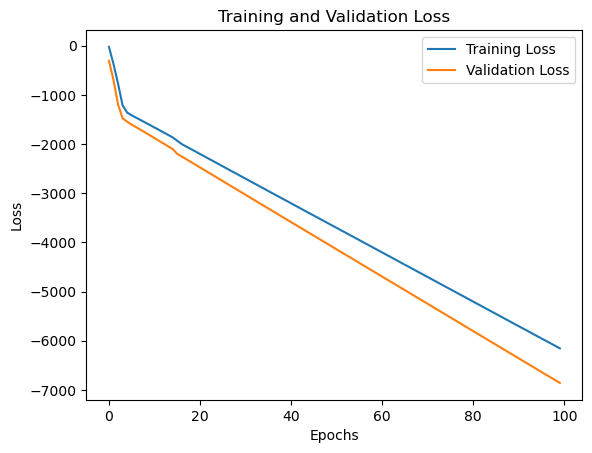

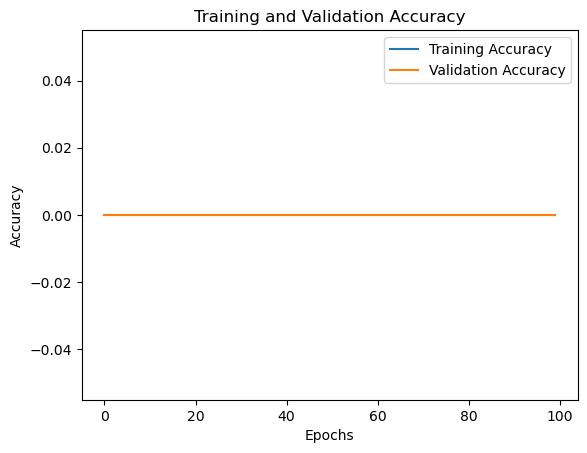

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(h['loss'], label='Training Loss')
plt.plot(h['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training & validation accuracy
plt.plot(h['accuracy'], label='Training Accuracy')
plt.plot(h['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()